In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
from pathlib import Path

import pandas as pd
from skimage import io
from skimage.transform import resize


def load_images(images_path, csv, samples, height=28, width=28, anti_aliasing=False):
    images_list = []
    labels = []
    
    # List all files on the way
    list_files = sorted([os.path.join(images_path, file)
                         for file in os.listdir(images_path) if file.endswith('.png')])
    
    list_files = list_files[: samples]
    
    # Read the csv that contains the information of the images
    df = pd.read_csv(csv)
    
    # Take the image only if it exists in the csv file
    for filename in list_files:
        image_id = int(Path(filename).stem)

        sub_df = df[df["id"] == image_id]
        if sub_df.empty:
            continue

        images_list.append(resize(io.imread(filename, as_gray=True), (height, width), anti_aliasing=anti_aliasing))
        labels.append(sub_df.iloc[0]["boneage"])
        
    del list_files

    return images_list, labels

In [4]:
from sklearn.model_selection import train_test_split

# GLOBALS
SAMPLES = 10000
# # TEST
# SAMPLES = 100

# Train

train_images_path = "../input/rsna-bone-age/boneage-training-dataset/boneage-training-dataset"
train_csv_path = "../input/rsna-bone-age/boneage-training-dataset.csv"

# Load
x, y = load_images(train_images_path, train_csv_path, SAMPLES)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

# To numpy array

x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Reshape to fit in Conv2D

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)



In [5]:
x_train.shape

(6700, 28, 28, 1)

In [6]:
# Imports components from Keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D

# Initializes a sequential model
model = Sequential()

# # First layer for simple Fully Connected
# model.add(Dense(10, activation="relu", input_shape=(784,)))

# Conv2D
model.add(Conv2D(10, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))

# # Second layer
# model.add(Conv2D(10, kernel_size=3, activation="relu"))

# Flatten
model.add(Flatten())

# Third layer
model.add(Dense(5, activation="relu"))

# Output layer
model.add(Dense(1, activation="linear"))

# Compile model
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["accuracy", "mean_squared_error"]
)

In [7]:
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=10
)

Epoch 1/10
168/168 [==============================] - 1s 8ms/step - loss: 5484.8628 - accuracy: 0.0000e+00 - mean_squared_error: 5484.8628 - val_loss: 1794.1440 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1794.1440
Epoch 2/10
168/168 [==============================] - 1s 6ms/step - loss: 1735.1140 - accuracy: 0.0000e+00 - mean_squared_error: 1735.1140 - val_loss: 1694.8724 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1694.8724
Epoch 3/10
168/168 [==============================] - 1s 6ms/step - loss: 1691.1154 - accuracy: 0.0000e+00 - mean_squared_error: 1691.1154 - val_loss: 1690.6260 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1690.6260
Epoch 4/10
168/168 [==============================] - 1s 6ms/step - loss: 1687.1829 - accuracy: 0.0000e+00 - mean_squared_error: 1687.1829 - val_loss: 1689.1204 - val_accuracy: 0.0000e+00 - val_mean_squared_error: 1689.1204
Epoch 5/10
168/168 [==============================] - 1s 7ms/step - loss: 1678.9390 - accuracy: 0.0000e+

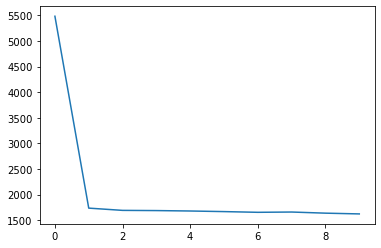

In [8]:
from matplotlib import pyplot

# Error medio cuadrado
pyplot.plot(history.history['mean_squared_error'])

Text(0, 0.5, 'Predicted Age (Months)')

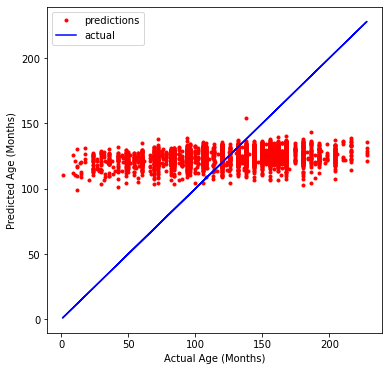

In [9]:
# From K Scott Mader notebook
from matplotlib import pyplot

y_pred = model.predict(x_test)

fig, ax1 = pyplot.subplots(1,1, figsize = (6,6))
ax1.plot(y_test, y_pred, 'r.', label = 'predictions')
ax1.plot(y_test, y_test, 'b-', label = 'actual')
ax1.legend()
ax1.set_xlabel('Actual Age (Months)')
ax1.set_ylabel('Predicted Age (Months)')

In [10]:
from keras.models import load_model

model.save('./my_model.h5', overwrite=True)  # creates a HDF5 file 'my_model.h5'
# del model  # deletes the existing model

In [11]:
# from keras.models import load_model

# # returns a compiled model
# # identical to the previous one
# model = load_model('./my_model.h5')